In [1]:
import os
from sklearn.utils import shuffle
import time
import cv2
import tqdm
from PIL import Image
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation

In [2]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten, Dropout
from keras.layers import Input, Concatenate
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
#from misc_layers import MinibatchDiscrimination, SubPixelUpscaling, CustomLRELU, bilinear2x
#from keras.contrib.layers import SubPixelUpscaling
import keras.backend as K
from keras.initializers import RandomNormal
K.set_image_data_format('channels_last')

In [3]:
import glob
os.environ['KERAS_BACKEND'] = 'tensorflow'
from sklearn.utils import shuffle
import scipy
import imageio
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
from scipy.interpolate import splrep 

from collections import deque

import numpy as np

np.random.seed(1337)

In [4]:
np.random.seed(42)

def get_gen_normal(noise_shape):
  noise_shape = noise_shape

  kernel_init = 'glorot_uniform'

  gen_input = Input(shape=noise_shape)

  generator = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(1,1), padding="valid", data_format="channels_last", kernel_initializer=kernel_init)(gen_input)
  generator = BatchNormalization(momentum=0.5)(generator)
  generator = LeakyReLU(0.2)(generator)

  generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
  generator = BatchNormalization(momentum = 0.5)(generator)
  generator = LeakyReLU(0.2)(generator)
  
  generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
  generator = BatchNormalization(momentum = 0.5)(generator)
  generator = LeakyReLU(0.2)(generator)
  
  generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
  generator = BatchNormalization(momentum = 0.5)(generator)
  generator = LeakyReLU(0.2)(generator)
  
  generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
  generator = BatchNormalization(momentum = 0.5)(generator)
  generator = LeakyReLU(0.2)(generator)

  generator = Conv2DTranspose( filters=3, kernel_size=(1,1), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
  generator = Activation('tanh')(generator)

  gen_opt = Adam(lr=0.00015, beta_1=0.5)
  generator_model = Model(inputs=gen_input, outputs=generator)
  generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
  generator_model.summary()

  return generator_model

In [5]:
def get_disc_normal(image_shape=(64, 64, 3)):
  image_shape = image_shape

  dropout_prob = 0.4
  dis_input = Input(shape=image_shape)
  kernel_init = "glorot_uniform"

  discriminator = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(dis_input)
  discriminator = LeakyReLU(0.2)(discriminator)

  discriminator = Conv2D( filters=128, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum= 0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)

  discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum = 0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)
  
  discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum = 0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)

  discriminator = Flatten()(discriminator)

  discriminator = Dense(1)(discriminator)
  discriminator = Activation('sigmoid')(discriminator)

  dis_opt = Adam(lr=0.0002, beta_1=0.5)
  discriminator_model = Model(inputs=dis_input, outputs=discriminator)
  discriminator_model.compile(optimizer=dis_opt, loss="binary_crossentropy", metrics=['accuracy'])
  discriminator_model.summary()

  return discriminator_model

In [6]:
from collections import deque

np.random.seed(1337)

In [7]:
def norm_img(img):
  img = (img/127.5) - 1
  return img

def denorm_img(img):
  img = ( img + 1 ) * 127.5
  return img

In [19]:
def sample_from_dataset( batch_size, image_shape, data_dir = None, data = None):
  sample_dim = (batch_size,) + image_shape
  sample = np.empty(sample_dim, dtype=np.float32)
  all_data_dirlist = list(glob.glob(data_dir))
  sample_imgs_paths = np.random.choice(all_data_dirlist, batch_size)
  print(f'The number of images is {sample_imgs_paths}')
  for index,img_filename in enumerate(sample_imgs_paths):
    image = Image.open(img_filename)
    #print(f'The shape of the image is {image.shape}')
    image = image.resize(image_shape[:-1])
    #print(f'The shape of the image after resize is {image.sh}')
    image = image.convert('RGB')
    image = np.asarray(image)
    image = norm_img(image)
    print(image)
    sample[index,...] = image
  print(f'The shape of the sample is {sample.shape}')
  return sample

In [9]:
def gen_noise( batch_size, noise_shape):
  return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [10]:
def generate_images( generator, save_dir):
  noise = gen_noise(batch_size, noise_shape)
  fake_data_X = generator.predict(noise)
  print("Displaying generated images")
  plt.figure(figsize=(4,4))
  gs1 = gridspec.GridSpec(4,4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice( fake_data_X.shape[0], 16, replace=False)
  for i in range(16):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    rand_index = rand_indices[i]
    image = fake_data_X[rand_index, :, :, :]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(save_dir+str(time.time())+"_GENimage.png", bbox_inches='tight', pad_inches=0)
  plt.show()

In [11]:
def save_img_batch(img_batch, img_save_dir):
  plt.figure(figsize=(4,4))
  gs1 = gridspec.GridSpec(4,4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice(img_batch.shape[0], 16,replace=False)
  for i in range(16):
    #plt.subplot(4, 4, i+1)
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    rand_index = rand_indices[i]
    image = img_batch[rand_index, :,:,:]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
  plt.show()   

In [12]:
noise_shape = (1,1,100)
num_steps = 100
batch_size = 64
image_shape = None
img_save_dir = "/content/drive/MyDrive/Datasets/Anime Character Output"
save_model = True
image_shape = (64,64,3)
data_dir = "/content/drive/MyDrive/Datasets/Anime Character Images/*.png"

log_dir = img_save_dir
save_model_dir = img_save_dir

In [13]:
discriminator = get_disc_normal(image_shape=image_shape)
generator = get_gen_normal(noise_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 100)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                           

In [14]:
discriminator.trainable = False

opt = Adam(lr=0.00015, beta_1=0.5)
gen_inp = Input(shape=noise_shape)
GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)
gan = Model(inputs=GAN_inp, outputs=GAN_opt)
gan.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 1)                 2768321   
                                                                 
Total params: 2,768,321
Trainable params: 0
Non-trainable params: 2,768,321
_________________________________________________________________


In [15]:
avg_disc_fake_loss = deque([0], maxlen=250)
avg_disc_real_loss = deque([0], maxlen=250)
avg_gan_loss = deque([0], maxlen=250)

Begin step:  0
The number of images is ['/content/drive/MyDrive/Datasets/Anime Character Images/face_69_86_3.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_113_159_74.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_273_224_40.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_47_205_56.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_186_166_142.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_286_179_31.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_265_720_58.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_166_145_4.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_242_207_41.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_158_300_13.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_188_282_53.png'
 '/content/drive/MyDrive/Datasets/Anime Character Images/face_268_119_99.png'
 '/content/drive/MyDrive/Data

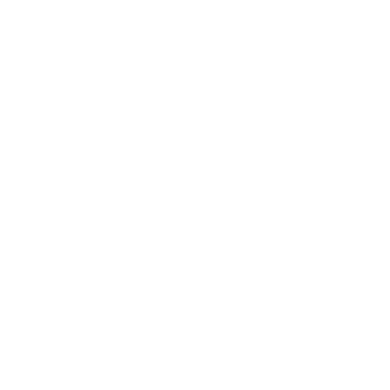

Disc: real loss: 0.749542 fake loss: 2.803794


ValueError: ignored

In [20]:
for step in range(num_steps): 
    tot_step = step
    print("Begin step: ", tot_step)
    step_begin_time = time.time() 
    
    real_data_X = sample_from_dataset(batch_size, image_shape, data_dir = data_dir)

    noise = gen_noise(batch_size,noise_shape)
    
    fake_data_X = generator.predict(noise)
    
    if (tot_step % 10) == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+"_image.png")

    #concatenate real and fake data samples    
    data_X = np.concatenate([real_data_X,fake_data_X])
    #add noise to the label inputs
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    
    
    fake_data_Y = np.random.random_sample(batch_size)*0.2
     
    data_Y = np.concatenate((real_data_Y,fake_data_Y))
        
    discriminator.trainable = True
    generator.trainable = False
    #training the discriminator on real and fake data can be done together, i.e., 
    #on the data_x and data_y, OR it can be done 
    #one by one as performed below. This is the safer choice and gives better results 
    #as compared to combining the real and generated samples.
    dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y)  
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y)   
    
    print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
    
    
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    generator.trainable = True

    GAN_X = gen_noise(batch_size,noise_shape)

    GAN_Y = real_data_Y
    
    discriminator.trainable = False
    
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))
    
    text_file = open(log_dir+"\\training_log.txt", "a")
    text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0],
                                                                                   dis_metrics_fake[0],gan_metrics[0]))
    text_file.close()
    avg_GAN_loss.append(gan_metrics[0])
    
        
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))
    
    if ((tot_step+1) % 500) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss)))    
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss)))    
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = True
        generator.trainable = True
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")
